This notbook contains an old version of how I used to do the plotting. Should delete

In [92]:
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.colors as mcolors
from functions import *

In [93]:
# These are the parameters for the case I want to analyze, which are not necessarily the same as those I generate

qhatmix=1.5 #GeV^2/fm
q=qhatmix*25.77 #fm^(-3)
EGev = 10 # Energy in Gev
E = EGev * 5.076 # Conversion factor to fm^-1
#z=0.4

Nc=3
CF=(Nc**2-1)/(2*Nc)

#a=lambda z: np.sqrt(q/w)
#Ou=(1-1j)/2*a
#Ov=(1+1j)/2*a

# Numerical parameters
ma=2 # This is the grid size in fm
u1max=ma
u2max=ma
v1max=ma
v2max=ma
u1min=-u1max
u2min=-u2max
v1min=-v1max
v2min=-v2max
#tmax=1e-2
t0=0
tmax=2 # Maximum medium length in fm


N=50 # Number of grid points. Should be at least 40 for okay results, ideally more
Nu1 = N
Nu2 = N
Nv1 = N
Nv2 = N


du1 = (u1max-u1min)/(Nu1-1)
du2 = (u2max-u2min)/(Nu2-1)
dv1 = (v1max-v1min)/(Nv1-1)
dv2 = (v2max-v2min)/(Nv2-1)
hu1,hu2,hv1,hv2 = int(Nu1/2),int(Nu2/2),int(Nv1/2),int(Nv2/2)

dtdusq=0.5

deltat=dtdusq*du1**2
Nt=round((tmax-t0)/deltat) # The number of time points is decided by the griz size and number of grid points
#Nt=round(Nt/10)*10

dt = (tmax-t0)/(Nt-1)
t = np.linspace(t0, tmax, Nt)

In [94]:
points = 10
lower_z = 0.01
upper_z = 0.5
log_oneover_z = np.linspace(np.log(1/lower_z),np.log(1/upper_z),points)
z_values = np.exp(-log_oneover_z)

# Use theta as proxy for p, as p ~ z*(1-z)*th*E
lower_th = 0.01
upper_th = 0.5 
log_oneover_th = np.linspace(np.log(1/lower_th),np.log(1/upper_th),points)
dth = log_oneover_th[0]-log_oneover_th[1]
log_oneover_th = np.append(log_oneover_th,log_oneover_th[points-1]-dth) # Added additional th value
theta_values = np.exp(-log_oneover_th)


th_points = len(theta_values)
z_points = len(z_values)

Z, TH = np.meshgrid(log_oneover_z,log_oneover_th)

In [95]:
log_oneover_z_big = np.linspace(log_oneover_z[0],log_oneover_z[-1],100)
log_oneover_th_big = np.linspace(log_oneover_th[0],log_oneover_th[-1],100)

z_values_big = np.exp(-log_oneover_z_big)
theta_values_big = np.exp(-log_oneover_th_big)


In [96]:
def w(z):
    return E*z*(1-z)

def O(z):
    return (1-1j)/2*np.sqrt(q/w(z))

def eik2(t,L,z,th):
    pre = 4*w(z)**2/(q*(1-2*z*1*(1-z))*t**2)
    exp1 = -1j*th**2*w(z)*t/2
    exp2=-q*th**2*t**3/12
    exp3=-q*th**2*(1-2*z*1*(1-z))*(L-t)*t**2/4
    return pre*np.exp(exp1)*np.exp(exp2)*(1-np.exp(exp3))

def eik2int(L,z,th):
    def real_fas(t,L,z,th):
        return np.real(eik2(t,L,z,th))
    def imag_fas(t,L,z,th):
        return np.imag(eik2(t,L,z,th))
    re = quad(real_fas,0,L,args=(L,z,th))[0]
    im = quad(imag_fas,0,L,args=(L,z,th))[0]

    return re + 1j*im

def fasit2Ncdiag(t,L,p1,p2,z):
    pre= -2*1j*w(z)
    
    num = 2*w(z)*O(z)/np.tan(O(z)*t)
    den = 2*w(z)*O(z)/np.tan(O(z)*t)+1j*q*(z**2+(1-z)**2)*(L-t)
    
    return pre*(1-num/den*np.exp(-1j*(p1**2+p2**2)/den))

def fasit2Ncdiagint(L,p1,p2,z):
    def real_fas(t,L,p1,p2,z):
        return np.real(fasit2Ncdiag(t,L,p1,p2,z))
    def imag_fas(t,L,p1,p2,z):
        return np.imag(fasit2Ncdiag(t,L,p1,p2,z))
    re = quad(real_fas,0,L,args=(L,p1,p2,z))[0]
    im = quad(imag_fas,0,L,args=(L,p1,p2,z))[0]

    return re + 1j*im


In [97]:
def Fmed_inout_scal(t,z,th):
    ex = -1j*np.tan(O(z)*t)*w(z)*th**2/(2*O(z))
    return -2*np.real(1-np.exp(ex))

def Fmed_inout_eik_scal(t,z,th):
    def integrand(t1,t,z,th):
        return np.sin(w(z)*th**2*(t-t1)/2)*np.exp(-q*th**2*(t-t1)**3/12)
    return -w(z)*th**2*quad(integrand,0,t,args=(t,z,th))[0]

def Fmed_inin_scal(t,z,th):
    p1=th*w(z)
    p2=0
    return th**2/2*np.real(fasit2Ncdiagint(t,p1,p2,z))

def Fmed_inin_eik_scal(t,z,th):
    return th**2/2*np.real(eik2int(t,z,th))

def Fmed_scal(t,z,th):
    return Fmed_inin_scal(t,z,th)+Fmed_inout_scal(t,z,th)

def Fmed_eik_scal(t,z,th):
    return Fmed_inin_eik_scal(t,z,th)+Fmed_inout_eik_scal(t,z,th)

'''
def Fmed_scal(L,z,th):
    p1=th*w(z)
    p2=0
    return th**2/2*np.real(fasit2Ncdiagint(L,p1,p2,z))+Fmed_inout_scal(z,th,L)

def Fmed_eik_scal(L,z,th):
    return th**2/2*np.real(eik2int(L,z,th))+Fmed_inout_eik_scal(z,th,L)
'''

'\ndef Fmed_scal(L,z,th):\n    p1=th*w(z)\n    p2=0\n    return th**2/2*np.real(fasit2Ncdiagint(L,p1,p2,z))+Fmed_inout_scal(z,th,L)\n\ndef Fmed_eik_scal(L,z,th):\n    return th**2/2*np.real(eik2int(L,z,th))+Fmed_inout_eik_scal(z,th,L)\n'

In [98]:
Fmed_inout = np.vectorize(Fmed_inout_scal)
Fmed_inout_eik = np.vectorize(Fmed_inout_eik_scal)

Fmed_inin = np.vectorize(Fmed_inin_scal)
Fmed_inin_eik = np.vectorize(Fmed_inin_eik_scal)

Fmed_diag = np.vectorize(Fmed_scal)
Fmed_diag_eik = np.vectorize(Fmed_eik_scal)

In [99]:
def round_to_significant_digits(number, significant_digits):
    if number !=0:
        # Calculate the number of decimal places to round to
        decimal_places = significant_digits - int(np.floor(np.log10(abs(number)))) - 1

        # Round the number to the specified number of decimal places
        rounded_number = round(number, decimal_places)
    else:
        rounded_number = 0

    return rounded_number

def round_sig(arr,dig):
    arr_round = arr.copy()
    for i,n in enumerate(arr_round):
        arr_round[i] = round_to_significant_digits(n,dig)
    return arr_round

In [100]:
def Fp(time_frac):
    time_n = int(len(t)*time_frac)-1

    Fp_full = np.zeros([th_points,z_points])
    Fp_Nc = np.zeros([th_points,z_points])
    Fp_diag = np.zeros([th_points,z_points])
    Fp_diag_true = np.zeros([th_points,z_points])

    for i,theta in enumerate(theta_values):
        for j,z in enumerate(z_values):

            all = np.load(f'{filename}_theta={theta:.3f}_z={z:.3f}_L={tmax}_E={EGev}_gridpoints={N}_gridsize={grid_size}.npy')

            full2 = all[2]
            Nc2 = all[4]
            diag2 = all[6]
            diag2_fasit = all[8]

            Fp_full[i,j] = np.real(full2[time_n])
            Fp_Nc[i,j] = np.real(Nc2[time_n])
            Fp_diag[i,j] = np.real(diag2[time_n])
            Fp_diag_true[i,j] = np.real(diag2_fasit[time_n])
        
    return  Fp_full,Fp_Nc,Fp_diag,Fp_diag_true


In [101]:
def Fmed(time_frac):
    time_n = int(len(t)*time_frac)-1
    time = t[time_n]

    inin_full = np.zeros([th_points,z_points])
    inin_Nc = np.zeros([th_points,z_points])   
    inin_diag = np.zeros([th_points,z_points])
    inin_diag_true = np.zeros([th_points,z_points])
    inout_full = np.zeros([th_points,z_points])


    for i,theta in enumerate(theta_values):
        for j,z in enumerate(z_values):

            all = np.load(f'{filename}_theta={theta:.3f}_z={z:.3f}_L={tmax}_E={EGev}_gridpoints={N}_gridsize={grid_size}.npy')

            full2 = all[2]
            Nc2 = all[4]
            diag2 = all[6]
            diag2_fasit = all[8]

            inin_full[i,j] = theta**2/2*np.real(full2[time_n])
            inin_Nc[i,j] = theta**2/2*np.real(Nc2[time_n])
            inin_diag[i,j] = theta**2/2*np.real(diag2[time_n])
            inin_diag_true[i,j] = theta**2/2*np.real(diag2_fasit[time_n])

            inout_full[i,j] = Fmed_inout(time,z,theta)

    Fmed_full = inin_full + inout_full
    Fmed_Nc = inin_Nc + inout_full
    Fmed_diag = inin_diag + inout_full
    Fmed_diag_true = inin_diag_true + inout_full


    return Fmed_full,Fmed_Nc,Fmed_diag,Fmed_diag_true



In [102]:
def pl(zvalues,cent,time,name=0,log = False,mima=0, x=TH,y=Z,show=True):

    def get_ticks(z,c,n):
        ma=np.max(z)
        mi=np.min(z)

        if type(mima)!=int:
            mi = mima[0]
            ma = mima[1]
        
        step=(ma-mi)/(n-1)
        psteps=round((ma-c)/step)
        msteps=round((c-mi)/step)
        
        ma_n = c+psteps*step
        mi_n = c-msteps*step
        ticks=np.linspace(mi_n,ma_n,n)
        lines=np.linspace(mi_n-step/2,ma_n+step/2,n+1)

        ticks = round_sig(ticks,2)
        
        return ticks, lines

    plt.rcParams['text.usetex'] = True

    fig = plt.figure(figsize=(8,6))
    left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
    ax = fig.add_axes([left, bottom, width, height]) 

    plt.tick_params(axis='both',which='both', right=True, top=True, bottom=True, direction='in', labelsize=18)

    if log:
        from matplotlib.colors import LogNorm
        max_lvl = 2
        min_lvl = -4
        n_lvl = (max_lvl-min_lvl)+1
        levels = np.logspace(-4,2,13)
        levels = np.logspace(min_lvl,max_lvl,n_lvl)
        cp = plt.contourf(x,y,zvalues,levels=levels,cmap=plt.get_cmap('YlOrRd'),norm = LogNorm())

        def fmt(x, pos):
            a, b = '{:.0e}'.format(x).split('e')
            b = int(b)
            return r'$ 10^{{{}}}$'.format(b)

        '''def fmt(x, pos):
            a, b = '{:.0e}'.format(x).split('e')
            b = int(b)
            return r'${} \times 10^{{{}}}$'.format(a, b)'''

        cbar = plt.colorbar(cp, format=ticker.FuncFormatter(fmt))
        cbar.ax.tick_params(labelsize=18)

    else:
        num = 9
        '''
        if type(mima)!=int:
            zmi = mima[0]
            zma = mima[1]
            Z_ = zvalues.copy()
            Z_[Z_>zma] = zma
            Z_[Z_<zmi] = zmi
            ticks,lines = get_ticks(Z_,cent,num)
        '''
        ticks,lines = get_ticks(zvalues,cent,num)

        if abs(cent-lines[0]) < abs(cent-lines[num]):
            cmax = lines[num]
            cmin = 2*cent-cmax
        else:
            cmin = lines[0]
            cmax = 2*cent-cmin
        '''
        if type(mima)!=int:
            zvalues[zvalues > ticks.max()] = ticks.max()
            zvalues[zvalues < ticks.min()] = ticks.min()
        '''
        cp = plt.contourf(x, y,zvalues,levels=lines,vmin=cmin,vmax = cmax,cmap=plt.get_cmap('RdBu_r'))
        cbar = plt.colorbar(ticks=ticks)
        cbar.ax.tick_params(labelsize=18)

    ax.set_title(r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,EGev),fontsize=14)

    #ax.text(1.3,np.max(log_oneover_z)-0.25,r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,EGev),fontsize = 13)


    ax.set_xlabel(r'$\log 1/ \theta$', fontsize=20)
    ax.set_ylabel(r'$\log 1/z$', fontsize=20)
    
    if name !=0:
        plt.savefig(f'plots/{name}_{EGev}.png', bbox_inches='tight')
    
    if show:
        plt.show()

In [103]:
def time_plot(z_n,theta_n,plt_Fmed=False,pl_full=True,pl_Nc=True,pl_diag=True,pl_eik=True):
    theta = theta_values[theta_n]
    z = z_values[z_n]

    all = np.load(f'{filename}_theta={theta:.3f}_z={z:.3f}_L={tmax}_E={EGev}_gridpoints={N}_gridsize={grid_size}.npy')
    full2 = all[2]
    Nc2 = all[4]
    diag2 = all[6]
    diag2_fasit = all[8]

    eik = t.copy()
    for i in range(1,len(t)):
        eik[i] = np.real(eik2int(t[i],z,theta))
    
    if plt_Fmed:
        inout = Fmed_inout(t,z,theta)
        inout_eik = Fmed_inout_eik(t,z,theta)

        full2 = theta**2/2*np.real(full2)+inout
        Nc2 = theta**2/2*np.real(Nc2)+inout
        diag2 = theta**2/2*np.real(diag2)+inout
        diag2_fasit = theta**2/2*np.real(diag2_fasit) + inout

        eik = theta**2/2*eik + inout_eik

    error = np.abs(np.real(diag2)-np.real(diag2_fasit))

    plt.rcParams['text.usetex'] = True

    if pl_full:
        plt.plot(t,np.real(full2), label=r'Numeric $N_c=3$')
        plt.fill_between(t, np.real(full2)-error, np.real(full2)+error, alpha=.3)
    if pl_Nc:
        plt.plot(t,np.real(Nc2), label=r'Numeric large-$N_c$')
        plt.fill_between(t, np.real(Nc2)-error, np.real(Nc2)+error, alpha=.3)
    #plt.plot(t,np.real(diag2), label='K2 Numeric-diag-re')
    if pl_diag:
        plt.plot(t,np.real(diag2_fasit), label=r'Analytic large-$N_c$ hom')
    if pl_eik:
        plt.plot(t,eik, label=r'Analytic large-$N_c$ and eikonal hom')

    plt.xlabel(r'$\mathrm{time\,[fm]}$',fontsize =12)
    if plt_Fmed:
        plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =12)
    else:
        plt.ylabel(r'$F(\mathbf{p})$',fontsize =12)
    plt.title(r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, \theta = %.2f,\,z=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,theta,z,EGev),fontsize=14)


    plt.legend(loc="upper left")
    if plt_Fmed and not pl_eik:
        plt.savefig(f'plots/Fmed_time_{EGev}.png', bbox_inches='tight')
    elif plt_Fmed and pl_eik:
        plt.savefig(f'plots/Fmed_time_eik_{EGev}.png', bbox_inches='tight')
    else:
        plt.savefig(f'plots/Fp_time_{EGev}.png', bbox_inches='tight')

    plt.show()
    

In [104]:
def theta_plot(time_frac,z_n,plt_Fmed=False,pl_full=True,pl_Nc=True,pl_diag=True,pl_eik=True):
    time_n = int(len(t)*time_frac)-1
    time = t[time_n]

    z = z_values[z_n]

    full_theta = theta_values.copy()
    Nc_theta = theta_values.copy()
    diag_theta = theta_values.copy()
    diag_fasit_theta = theta_values.copy()
    eik = theta_values.copy()

    for i,theta in enumerate(theta_values):

        all = np.load(f'{filename}_theta={theta:.3f}_z={z:.3f}_L={tmax}_E={EGev}_gridpoints={N}_gridsize={grid_size}.npy')
        full2 = all[2]
        Nc2 = all[4]
        diag2 = all[6]
        diag2_fasit = all[8]

        full_theta[i] = np.real(full2[time_n])
        Nc_theta[i] = np.real(Nc2[time_n])
        diag_theta[i] = np.real(diag2[time_n])
        diag_fasit_theta[i] = np.real(diag2_fasit[time_n])

        eik[i] = np.real(eik2int(time,z,theta))
    
        if plt_Fmed:
            inout = Fmed_inout(time,z,theta)
            inout_eik = Fmed_inout_eik(time,z,theta)
            
            full_theta[i] = theta**2/2*full_theta[i]+inout
            Nc_theta[i] = theta**2/2*Nc_theta[i]+inout
            diag_theta[i] = theta**2/2*diag_theta[i]+inout
            diag_fasit_theta[i] = theta**2/2*diag_fasit_theta[i]+inout

            eik[i] = theta**2/2*eik[i] + inout_eik


    error = np.abs(np.real(diag_theta)-np.real(diag_fasit_theta))


    plt.rcParams['text.usetex'] = True
    #plt.text(0.01,np.max(full_theta+error),r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,z=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,z,EGev),fontsize = 12)

    if pl_full:
        plt.semilogx(theta_values,full_theta, label=r'Numeric $N_c=3$')
        plt.fill_between(theta_values, full_theta-error, full_theta+error, alpha=.3)
    if pl_Nc:
        plt.semilogx(theta_values,Nc_theta, label=r'Numeric large-$N_c$')
        plt.fill_between(theta_values, Nc_theta-error, Nc_theta+error, alpha=.3)
    #plt.plot(theta_values,diag_theta, label='K2 Numeric-diag-re')
    

    

    if plt_Fmed:
        if pl_diag:
            plt.semilogx(theta_values_big,Fmed_diag(time,z,theta_values_big),label=r'Analytic large-$N_c$ hom')
        if pl_eik:
            plt.semilogx(theta_values_big,Fmed_diag_eik(time,z,theta_values_big),label=r'Analytic large-$N_c$ and eikonal hom')
    else:
        if pl_diag:
            plt.semilogx(theta_values,diag_fasit_theta, label=r'Analytic large-$N_c$ hom')
        if pl_eik:
            plt.semilogx(theta_values,eik,label=r'Analytic large-$N_c$ and eikonal hom')

    plt.xlabel(r'$\theta$',fontsize =12)
    if plt_Fmed:
        plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =12)
    else:
        plt.ylabel(r'$F(\mathbf{p})$',fontsize =12)
    plt.title(r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,z=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,z,EGev),fontsize=14)


    plt.legend(loc="upper left")

    if plt_Fmed:
        plt.savefig(f'plots/Fmed_theta_{EGev}.png', bbox_inches='tight')
    else:
        plt.savefig(f'plots/Fp_theta_{EGev}.png', bbox_inches='tight')


    plt.show()


In [105]:
def pt_plot(time_frac,z_n,Fmed=False):
    time_n = int(len(t)*time_frac)-1
    time = t[time_n]

    z = z_values[z_n]
    
    p_values = theta_values*w(z)
    Qs = np.sqrt(q*time)
    p_values_scaled = p_values/Qs

    full_theta = theta_values.copy()
    Nc_theta = theta_values.copy()
    diag_theta = theta_values.copy()
    diag_fasit_theta = theta_values.copy()
    eik = theta_values.copy()

    for i,theta in enumerate(theta_values):

        all = np.load(f'{filename}_theta={theta:.3f}_z={z:.3f}_L={tmax}_E={EGev}_gridpoints={N}_gridsize={grid_size}.npy')
        full2 = all[2]
        Nc2 = all[4]
        diag2 = all[6]
        diag2_fasit = all[8]

        full_theta[i] = np.real(full2[time_n])
        Nc_theta[i] = np.real(Nc2[time_n])
        diag_theta[i] = np.real(diag2[time_n])
        diag_fasit_theta[i] = np.real(diag2_fasit[time_n])

        eik[i] = np.real(eik2int(time,z,theta))
    
        if Fmed:
            inout = Fmed_inout(z,theta,time)
            inout_eik = Fmed_inout_eik(z,theta,time)
            
            full_theta[i] = theta**2/2*full_theta[i]+inout
            Nc_theta[i] = theta**2/2*Nc_theta[i]+inout
            diag_theta[i] = theta**2/2*diag_theta[i]+inout
            diag_fasit_theta[i] = theta**2/2*diag_fasit_theta[i]+inout

            eik[i] = theta**2/2*eik[i] + inout_eik


    error = np.abs(np.real(diag_theta)-np.real(diag_fasit_theta))


    plt.rcParams['text.usetex'] = True
    #plt.text(0.01,np.max(full_theta+error),r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,z=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,z,EGev),fontsize = 12)


    plt.semilogx(p_values_scaled,full_theta, label=r'Numeric $N_c=3$')
    plt.semilogx(p_values_scaled,Nc_theta, label=r'Numeric large-$N_c$')
    #plt.plot(theta_values,diag_theta, label='K2 Numeric-diag-re')
    plt.semilogx(p_values_scaled,diag_fasit_theta, label=r'Analytic large-$N_c$ hom')

    plt.fill_between(p_values_scaled, full_theta-error, full_theta+error, alpha=.3)

    plt.semilogx(p_values_scaled,eik,label=r'Analytic large-$N_c$ and eikonal hom')


    plt.xlabel(r'$p_\perp/Q_s$',fontsize =12)
    if Fmed:
        plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =12)
    else:
        plt.ylabel(r'$F(\mathbf{p})$',fontsize =12)
    plt.title(r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,z=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,z,EGev),fontsize=14)


    plt.legend(loc="upper left")

    if Fmed:
        plt.savefig(f'plots/Fmed_pt_{EGev}.png', bbox_inches='tight')
    else:
        plt.savefig(f'plots/Fp_pt_{EGev}.png', bbox_inches='tight')


    plt.show()


In [106]:
def z_plot(time_frac,theta_n,plt_Fmed=False,pl_full=True,pl_Nc=True,pl_diag=True,pl_eik=True):
    time_n = int(len(t)*time_frac)-1
    time = t[time_n]

    theta = theta_values[theta_n]

    full_z = np.array([])
    Nc_z = np.array([])
    diag_z = np.array([])
    diag_fasit_z = np.array([])
    eik = z_values.copy()

    for i,z in enumerate(z_values):
        all = np.load(f'{filename}_theta={theta:.3f}_z={z:.3f}_L={tmax}_E={EGev}_gridpoints={N}_gridsize={grid_size}.npy')
        full2 = all[2]
        Nc2 = all[4]
        diag2 = all[6]
        diag2_fasit = all[8]

        full_z = np.append(full_z,np.real(full2[time_n]))
        Nc_z = np.append(Nc_z,np.real(Nc2[time_n]))
        diag_z = np.append(diag_z,np.real(diag2[time_n]))
        diag_fasit_z = np.append(diag_fasit_z,np.real(diag2_fasit[time_n]))

        eik[i] = np.real(eik2int(time,z,theta))

    if plt_Fmed:
        inout = Fmed_inout(time,z_values,theta)
        inout_eik = Fmed_inout_eik(time,z_values,theta)

        full_z = theta**2/2*full_z+inout
        Nc_z = theta**2/2*Nc_z+inout
        diag_z = theta**2/2*np.real(diag_z)+inout
        diag_fasit_z = theta**2/2*diag_fasit_z + inout

        eik = theta**2/2*eik + inout_eik


    error = np.abs(np.real(diag_z)-np.real(diag_fasit_z))

    plt.rcParams['text.usetex'] = True
    #plt.text(0.01,np.max(full_z+error),r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,\theta=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,theta,EGev),fontsize = 12)
    if pl_full:
        plt.semilogx(z_values,full_z, label=r'Numeric $N_c=3$')
        plt.fill_between(z_values, full_z-error, full_z+error, alpha=.3)
    if pl_Nc:
        plt.semilogx(z_values,Nc_z, label=r'Numeric large-$N_c$')
        plt.fill_between(z_values, Nc_z-error, Nc_z+error, alpha=.3)
    #plt.loglog(z_values,diag_z, label='K2 Numeric-diag-re')
    

    

    if plt_Fmed:
        if pl_diag:
            plt.semilogx(z_values_big,Fmed_diag(time,z_values_big,theta),label=r'Analytic large-$N_c$ hom')
        if pl_eik:
            plt.semilogx(z_values_big,Fmed_diag_eik(time,z_values_big,theta),label=r'Analytic large-$N_c$ and eikonal hom')
    else:
        if pl_diag:
            plt.semilogx(z_values,diag_fasit_z, label=r'Analytic large-$N_c$ hom')
        if pl_eik:
            plt.semilogx(z_values,eik,label=r'Analytic large-$N_c$ and eikonal hom')


    plt.xlabel(r'$z$',fontsize =12)
    if plt_Fmed:
        plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =12)
    else:
        plt.ylabel(r'$F(\mathbf{p})$',fontsize =12)
    plt.title(r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,\theta=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,theta,EGev),fontsize=14)

    plt.legend(loc="upper left")

    if plt_Fmed:
        plt.savefig(f'plots/Fmed_z_{EGev}.png', bbox_inches='tight')
    else:
        plt.savefig(f'plots/Fp_z_{EGev}.png', bbox_inches='tight')


    plt.show()

# F(p)

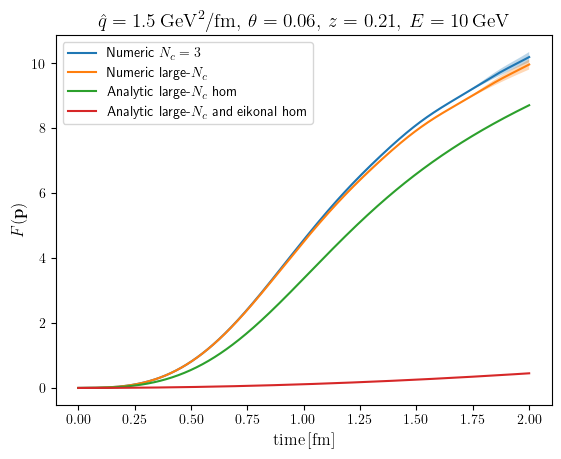

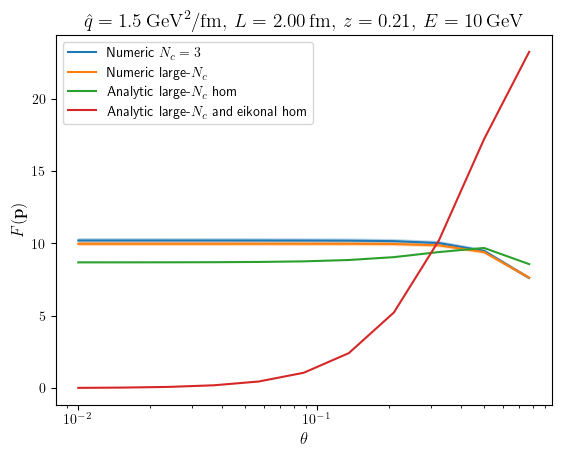

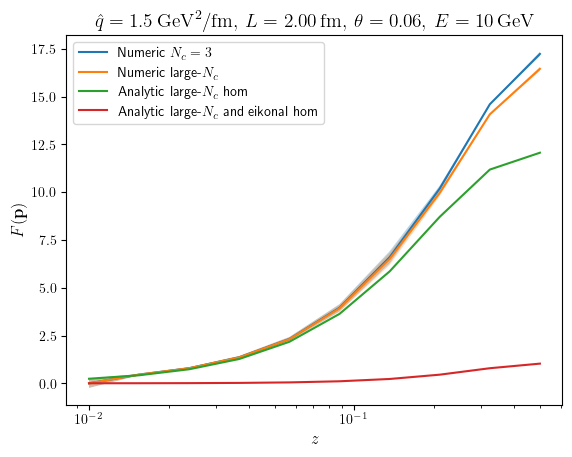

In [107]:
time_frac = 1
z_n=7
theta_n=4

time_plot(z_n,theta_n)
theta_plot(time_frac,z_n)
z_plot(time_frac,theta_n)

In [108]:
time_frac = 1
time_n = int(len(t)*time_frac)-1
time = t[time_n]

Fp_full,Fp_Nc,Fp_diag,Fp_diag_true = Fp(time_frac)

Fp_error_diag_full = abs(Fp_full-Fp_diag)/(1+abs(Fp_full))
Fp_error_Nc_full = abs(Fp_full-Fp_Nc)/(1+abs(Fp_full))
Fp_error_diag = abs(Fp_diag-Fp_diag_true)/(1+abs(Fp_diag_true))

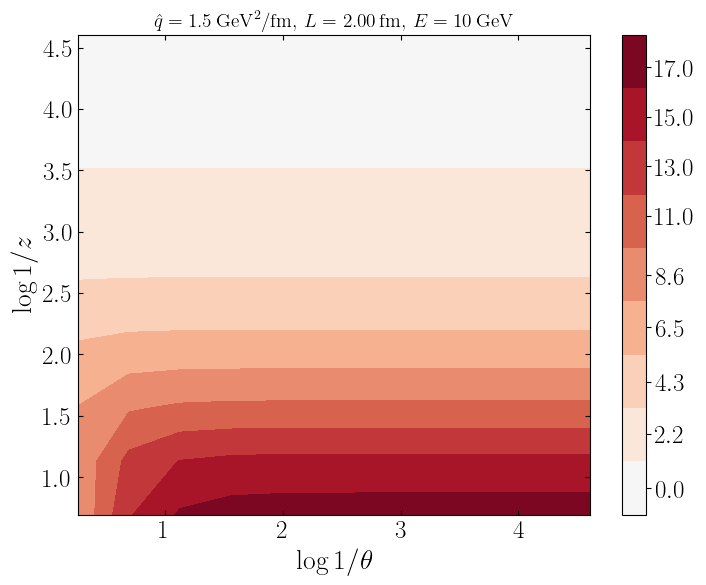

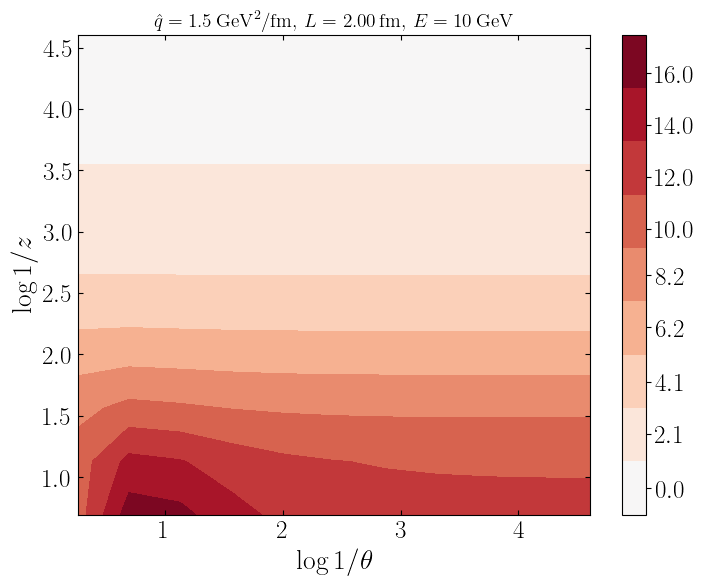

/var/folders/pg/l_nrfrtx4hb_l7x6sdwszd7w0000gn/T/ipykernel_5122/40114428.py:39: UserWarning: Log scale: values of z <= 0 have been masked
  cp = plt.contourf(x,y,zvalues,levels=levels,cmap=plt.get_cmap('YlOrRd'),norm = LogNorm())


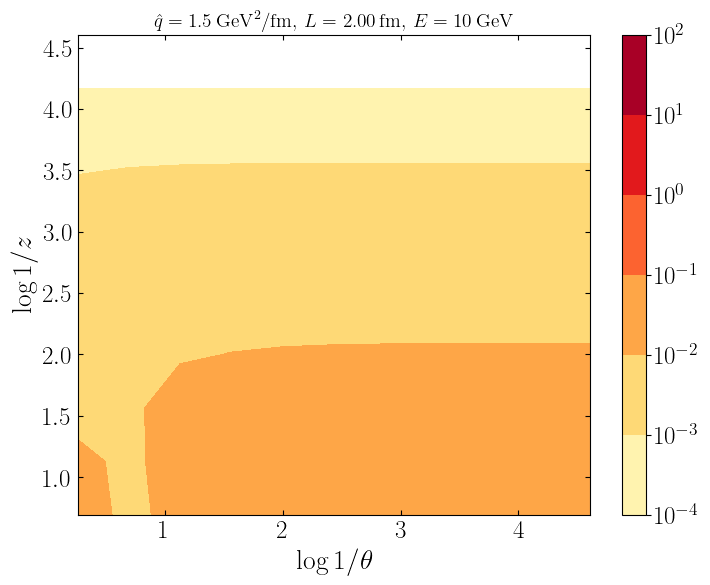

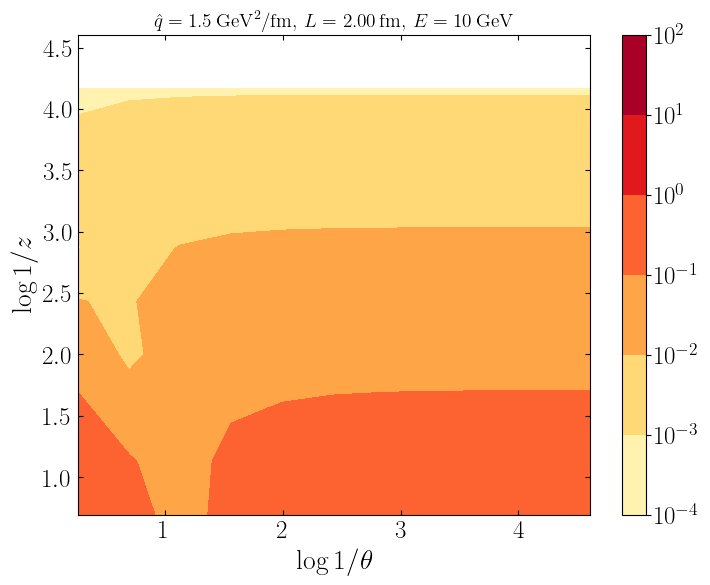

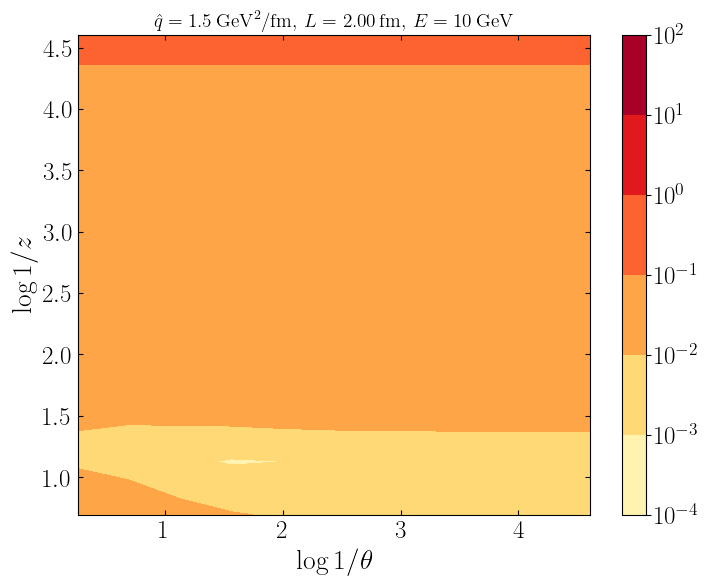

In [109]:
pl(Fp_full,0,time,name='Fp_full')
#pl(Fp_Nc,0,time,name='Fp_Nc')
pl(Fp_diag,0,time,name='Fp_diag')

pl(Fp_error_Nc_full,0,time,log=True)
pl(Fp_error_diag_full,0,time,log=True)
pl(Fp_error_diag,0,time,log=True)

# Fmed

0.6931471805599453 3.7358317403373924
0.6931471805599453 3.301162517512043


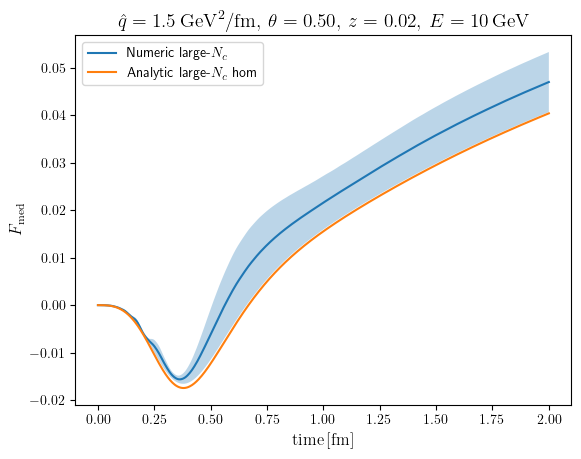

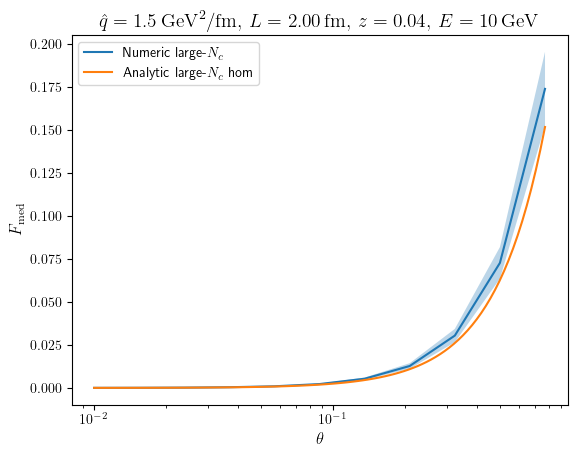

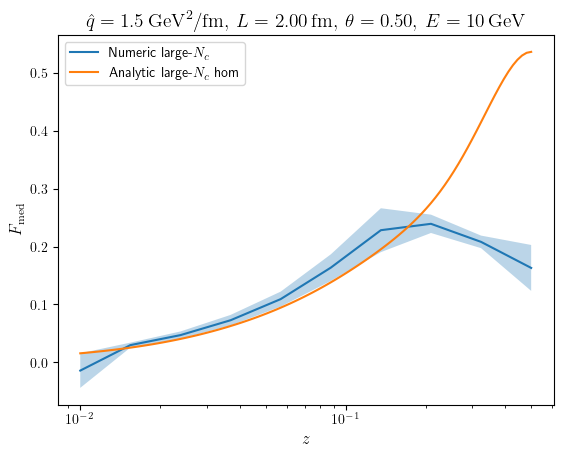

In [110]:
time_frac = 1
theta_t=9
z_t=2
print(log_oneover_th[theta_t],log_oneover_z[z_t])

theta_z = 9
z_th = 3
print(log_oneover_th[theta_z],log_oneover_z[z_th])
time_plot(z_t,theta_t,plt_Fmed=True,pl_full=False,pl_diag=True,pl_eik=False)
theta_plot(time_frac,z_th,plt_Fmed=True,pl_full=False,pl_diag=True,pl_eik=False)
#pt_plot(time_frac,z_n,Fmed=True)
z_plot(time_frac,theta_z,plt_Fmed=True,pl_full=False,pl_diag=True,pl_eik=False)

In [111]:
time_frac = 1
time_n = int(len(t)*time_frac)-1
time = t[time_n]

Fmed_full,Fmed_Nc,Fmed_diag_sim,Fmed_diag_true = Fmed(time_frac)

Fmed_error_diag_full = abs(Fmed_full-Fmed_diag_sim)/(1+abs(Fmed_full))
Fmed_error_Nc_full = abs(Fmed_full-Fmed_Nc)/(1+abs(Fmed_full))
Fmed_error_diag_Nc = abs(Fmed_Nc-Fmed_diag_sim)/(1+abs(Fmed_Nc))
Fmed_error_diag = abs(Fmed_diag_sim-Fmed_diag_true)/(1+abs(Fmed_diag_true))


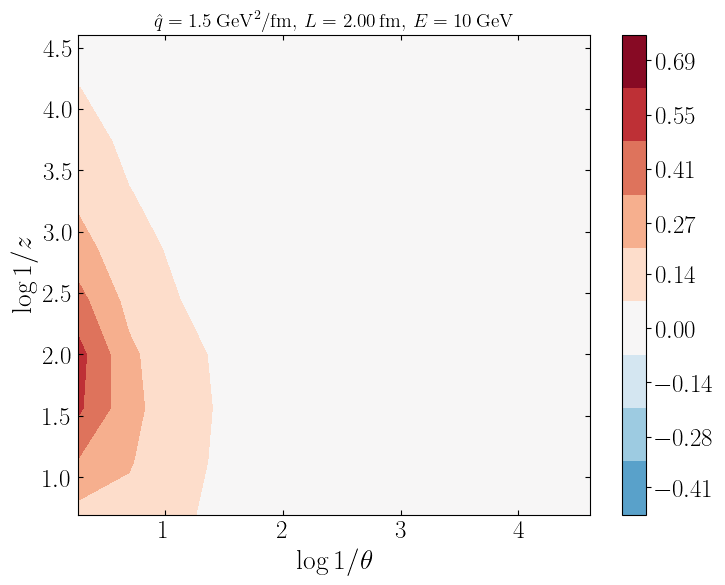

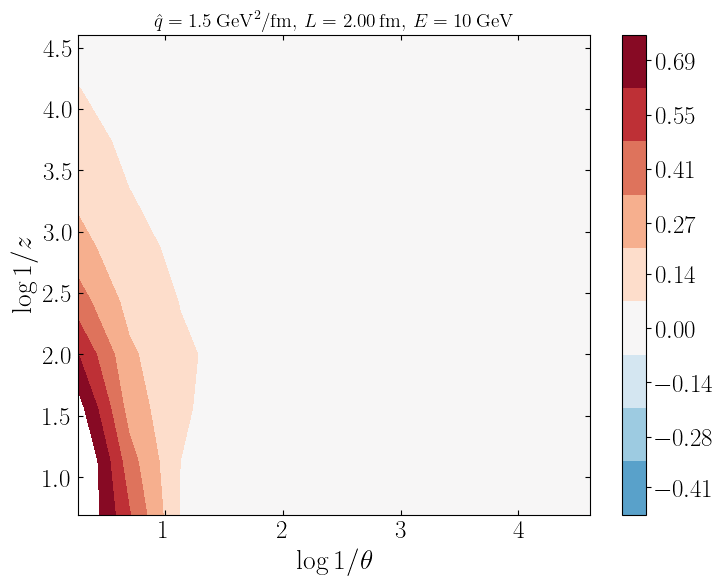

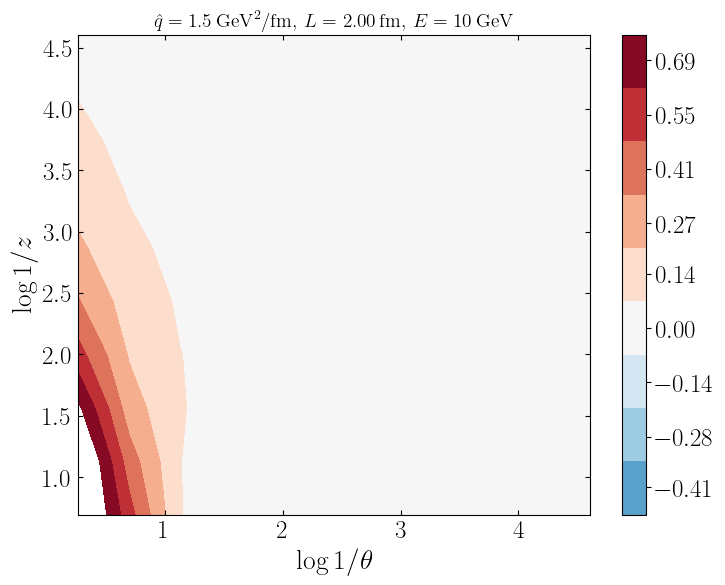

/var/folders/pg/l_nrfrtx4hb_l7x6sdwszd7w0000gn/T/ipykernel_5122/40114428.py:39: UserWarning: Log scale: values of z <= 0 have been masked
  cp = plt.contourf(x,y,zvalues,levels=levels,cmap=plt.get_cmap('YlOrRd'),norm = LogNorm())


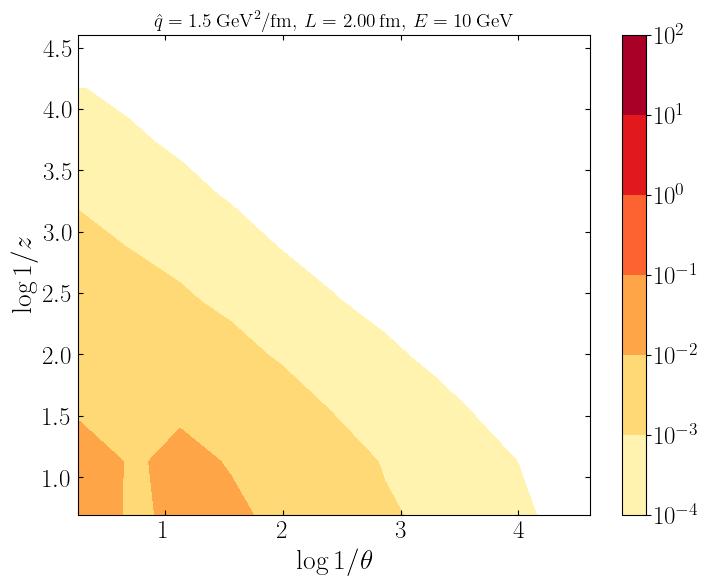

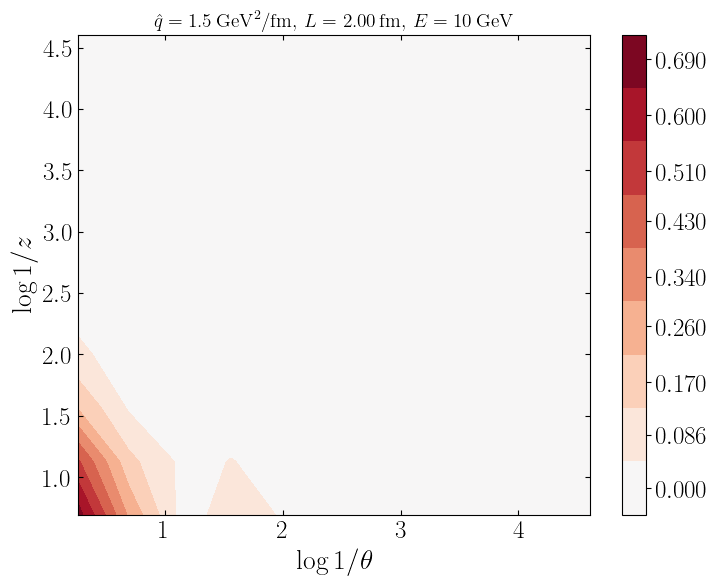

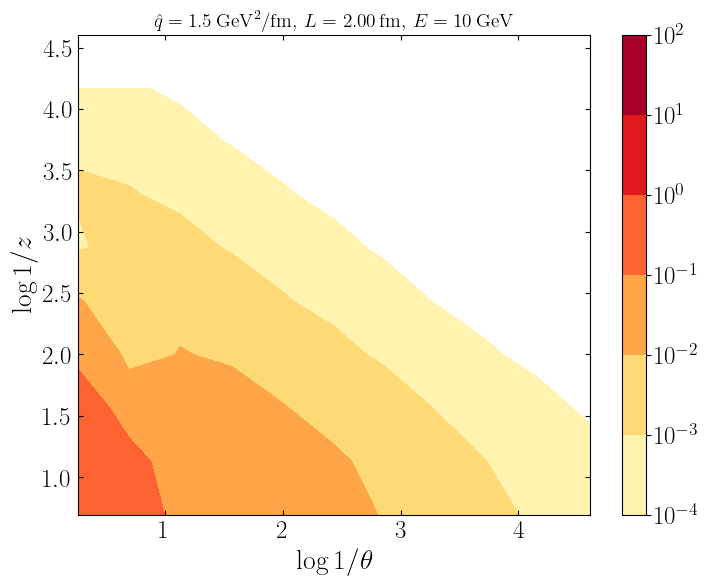

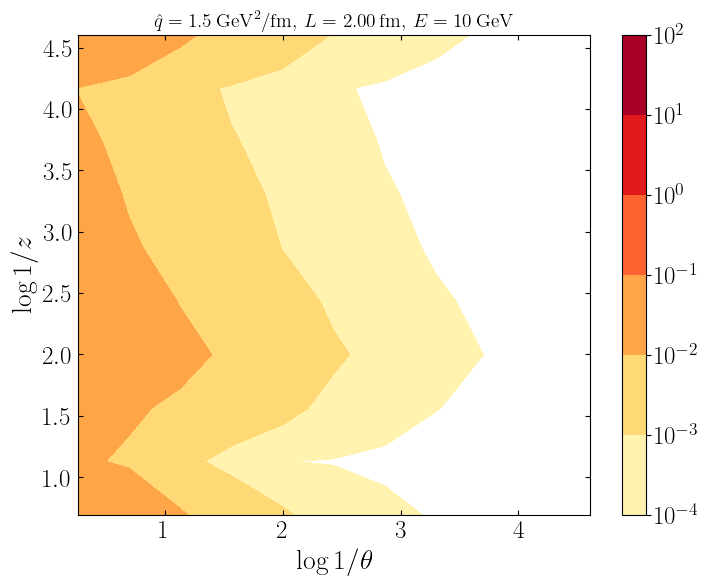

In [112]:
zmi = -0.4
zma = 0.7

pl(Fmed_full,0,time,name='Fmed_full',mima=[zmi,zma])
#pl(Fmed_Nc,0,time,name='Fmed_Nc')
pl(Fmed_diag_sim,0,time,mima=[zmi,zma])
pl(Fmed_diag_true,0,time,name='Fmed_diag_true',mima=[zmi,zma])

pl(Fmed_error_Nc_full,0,time,name='Fmed_difference_Nc_full',log=True)
pl(Fmed_error_diag_full,0,time,name='Fmed_difference_diag_full')
pl(Fmed_error_diag_full,0,time,name='Fmed_difference_diag_Nc',log=True)
pl(Fmed_error_diag,0,time,name='Fmed_error_diag',log=True)

# Eikonal

In [113]:
points = 100

t_vals = np.linspace(0.001,2,points)

lower_z = 0.001
upper_z = 0.5
log_oneover_z = np.linspace(np.log(1/lower_z),np.log(1/upper_z),points)
z_values = np.exp(-log_oneover_z)

# Use theta as proxy for p, as p ~ z*(1-z)*th*E
lower_th = 0.01
upper_th = 1
log_oneover_th = np.linspace(np.log(1/lower_th),np.log(1/upper_th),points)
theta_values = np.exp(-log_oneover_th)


In [114]:
L=2
t=L
th=0.2
z=0.4

qhatmix=1.5 #GeV^2/fm
q=qhatmix*25.77 #fm^(-3)
EGev = 100 # Energy in Gev
E = EGev * 5.076 # Conversion factor to fm^-1

ωc=q*L**2/2
print(ωc)
print(0.5*(1-np.sqrt(1-4*ωc/E)))



77.31
0.18743794942284997


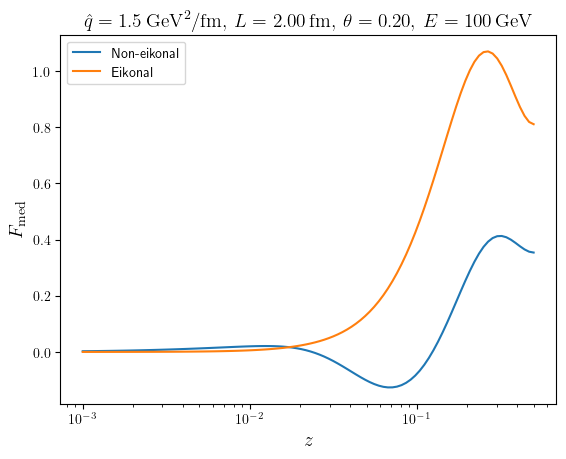

In [115]:
plt.semilogx(z_values,Fmed_diag(t,z_values,th),label=r'Non-eikonal')
plt.semilogx(z_values,Fmed_diag_eik(t,z_values,th),label=r'Eikonal')
plt.legend(loc="upper left")
plt.xlabel(r'$z$',fontsize =14)
plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =14)
plt.title(r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,\theta=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,t,th,EGev),fontsize=14)
plt.savefig(f'plots/eikonal/Fmed_z_{EGev}.png', bbox_inches='tight')
plt.show()

/var/folders/pg/l_nrfrtx4hb_l7x6sdwszd7w0000gn/T/ipykernel_5122/624782452.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  re = quad(real_fas,0,L,args=(L,z,th))[0]


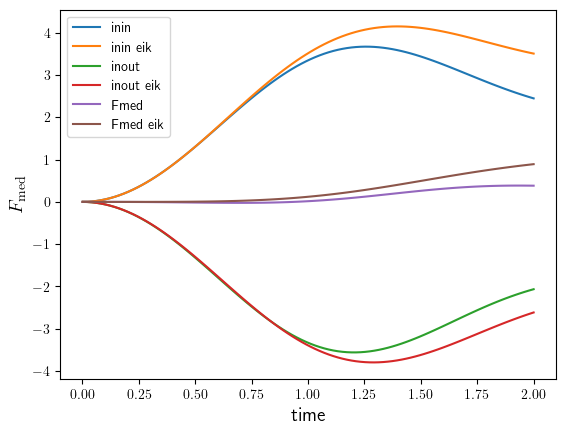

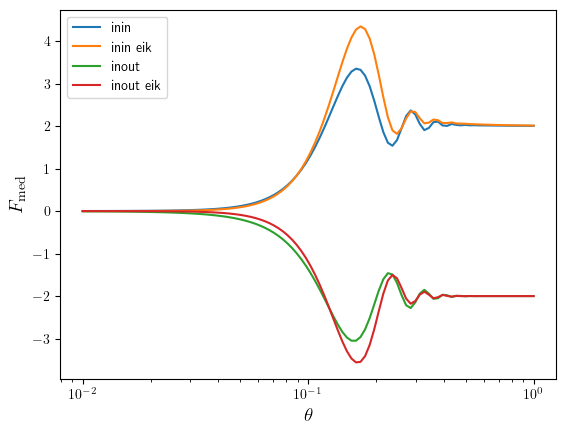

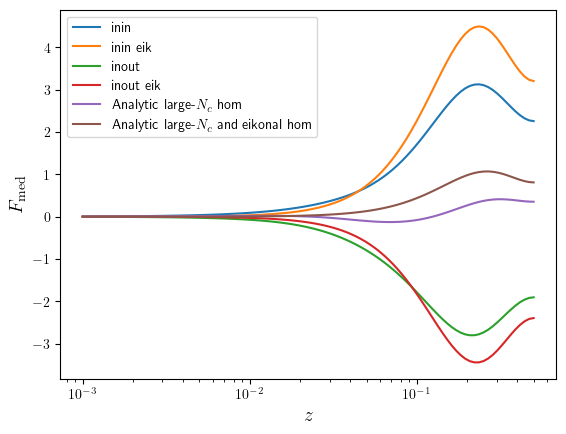

In [116]:
plt.rcParams['text.usetex'] = True
plt.plot(t_vals,Fmed_inin(t_vals,z,th),label=r'inin')
plt.plot(t_vals,Fmed_inin_eik(t_vals,z,th),label=r'inin eik')
plt.plot(t_vals,Fmed_inout(t_vals,z,th),label=r'inout')
plt.plot(t_vals,Fmed_inout_eik(t_vals,z,th),label=r'inout eik')
plt.plot(t_vals,Fmed_inin(t_vals,z,th)+Fmed_inout(t_vals,z,th),label=r'Fmed')
plt.plot(t_vals,Fmed_inin_eik(t_vals,z,th)+Fmed_inout_eik(t_vals,z,th),label=r'Fmed eik')
plt.legend(loc="upper left")
plt.xlabel('time',fontsize =14)
plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =14)
plt.show()

plt.semilogx(theta_values,Fmed_inin(t,z,theta_values),label=r'inin')
plt.semilogx(theta_values,Fmed_inin_eik(t,z,theta_values),label=r'inin eik')
plt.semilogx(theta_values,Fmed_inout(t,z,theta_values),label=r'inout')
plt.semilogx(theta_values,Fmed_inout_eik(t,z,theta_values),label=r'inout eik')
plt.legend(loc="upper left")
plt.xlabel(r'$\theta$',fontsize =14)
plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =14)
plt.show()

plt.semilogx(z_values,Fmed_inin(t,z_values,th),label=r'inin')
plt.semilogx(z_values,Fmed_inin_eik(t,z_values,th),label=r'inin eik')
plt.semilogx(z_values,Fmed_inout(t,z_values,th),label=r'inout')
plt.semilogx(z_values,Fmed_inout_eik(t,z_values,th),label=r'inout eik')

plt.semilogx(z_values,Fmed_diag(t,z_values,th),label=r'Analytic large-$N_c$ hom')
plt.semilogx(z_values,Fmed_diag_eik(t,z_values,th),label=r'Analytic large-$N_c$ and eikonal hom')
plt.legend(loc="upper left")
plt.xlabel(r'$z$',fontsize =14)
plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =14)
plt.show()

/var/folders/pg/l_nrfrtx4hb_l7x6sdwszd7w0000gn/T/ipykernel_5122/624782452.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  re = quad(real_fas,0,L,args=(L,z,th))[0]


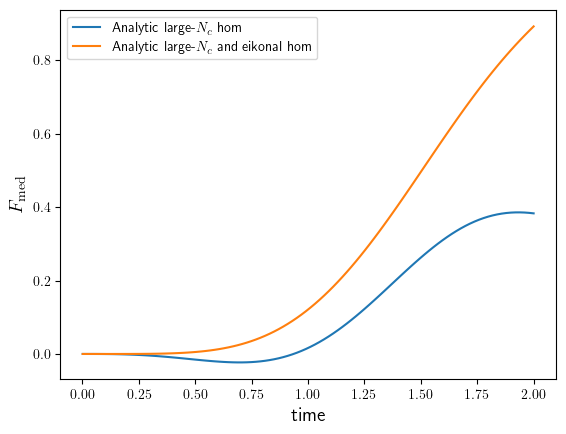

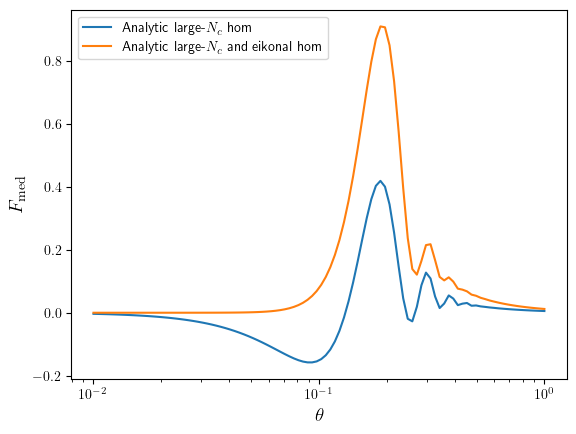

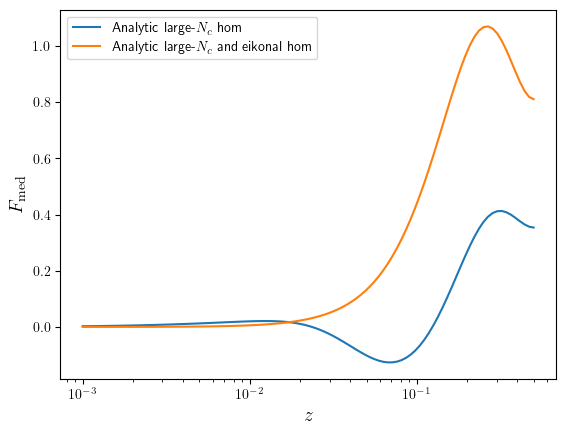

In [117]:
plt.rcParams['text.usetex'] = True
plt.plot(t_vals,Fmed_diag(t_vals,z,th),label=r'Analytic large-$N_c$ hom')
plt.plot(t_vals,Fmed_diag_eik(t_vals,z,th),label=r'Analytic large-$N_c$ and eikonal hom')
plt.legend(loc="upper left")
plt.xlabel('time',fontsize =14)
plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =14)
plt.show()

plt.semilogx(theta_values,Fmed_diag(t,z,theta_values),label=r'Analytic large-$N_c$ hom')
plt.semilogx(theta_values,Fmed_diag_eik(t,z,theta_values),label=r'Analytic large-$N_c$ and eikonal hom')
plt.legend(loc="upper left")
plt.xlabel(r'$\theta$',fontsize =14)
plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =14)
plt.show()

plt.semilogx(z_values,Fmed_diag(t,z_values,th),label=r'Analytic large-$N_c$ hom')
plt.semilogx(z_values,Fmed_diag_eik(t,z_values,th),label=r'Analytic large-$N_c$ and eikonal hom')
plt.legend(loc="upper left")
plt.xlabel(r'$z$',fontsize =14)
plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =14)
plt.show()



In [118]:
Z, TH = np.meshgrid(log_oneover_z,log_oneover_th)
Z_lin, TH_lin = np.meshgrid(z_values,theta_values)
lund = Fmed_diag(L,Z_lin,TH_lin)
lund_eik = Fmed_diag_eik(L,Z_lin,TH_lin)
lund_inin = Fmed_inin(L,Z_lin,TH_lin)
lund_inin_eik = Fmed_inin_eik(L,Z_lin,TH_lin)
lund_inout = Fmed_inout(L,Z_lin,TH_lin)
lund_inout_eik = Fmed_inout_eik(L,Z_lin,TH_lin)

In [119]:
lund_eik_error = abs(lund-lund_eik)/(1+abs(lund))
lund_inin_error = abs(lund_inin-lund_inin_eik)/(1+abs(lund_inin))
lund_ratio = abs(lund_eik)/(abs(lund))
lund_inin_ratio = abs(lund_inin_eik)/(abs(lund_inin))
lund_inout_ratio = abs(lund_inout_eik)/(abs(lund_inout))
lund_ratio_shit = abs(lund_inin_eik+lund_inout_eik)/(abs(lund_inin+lund_inout))


In [120]:
Qs = np.sqrt(q*L)

th_Qs_values = np.array([])
for z in z_values:
    th_Qs = np.sqrt(q*L)/(w(z))
    th_Qs_values = np.append(th_Qs_values,th_Qs)
log_oneover_th_Qs = np.log(1/th_Qs_values)

th_ho_values = np.array([])
for z in z_values:
    th_ho = (q*w(z))**(1/4)/(w(z))
    th_ho_values = np.append(th_ho_values,th_ho)
log_oneover_th_ho = np.log(1/th_ho_values)


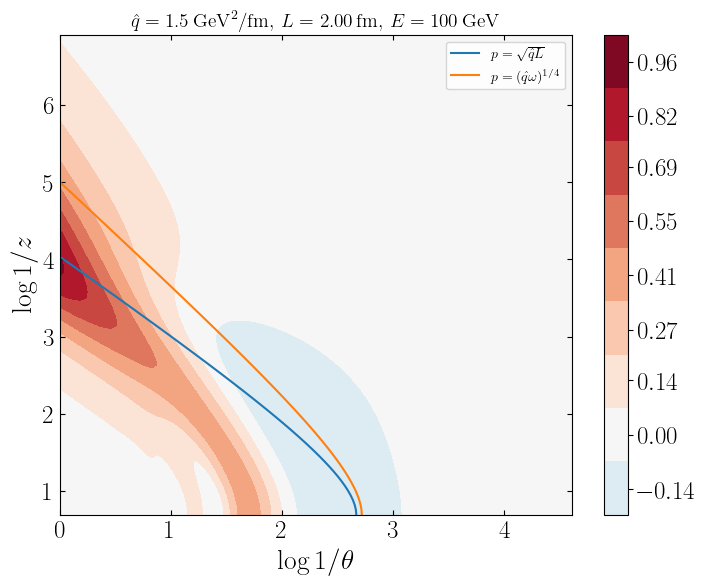

In [121]:
pl(lund,0,time,name='eikonal/Fmed',x=TH,y=Z,show=False)
plt.plot(log_oneover_th_Qs,log_oneover_z,label=r"$p=\sqrt{\hat q L}$")
plt.plot(log_oneover_th_ho,log_oneover_z,label=r"$p=(\hat q \omega)^{1/4}$")
plt.xlim(np.min(log_oneover_th),np.max(log_oneover_th))
plt.ylim(np.min(log_oneover_z),np.max(log_oneover_z))
plt.legend(loc="upper right")
plt.show()

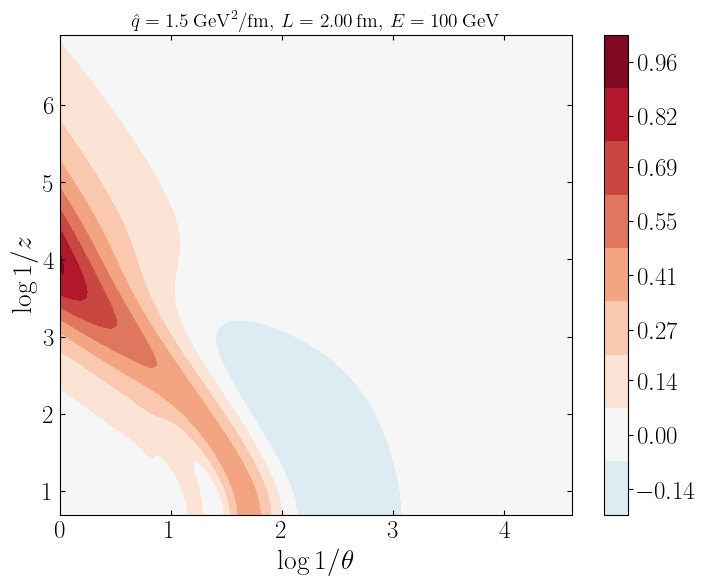

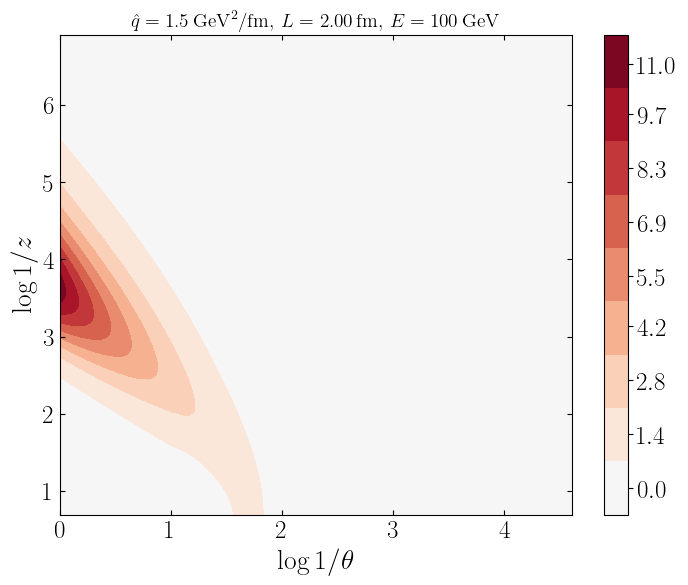

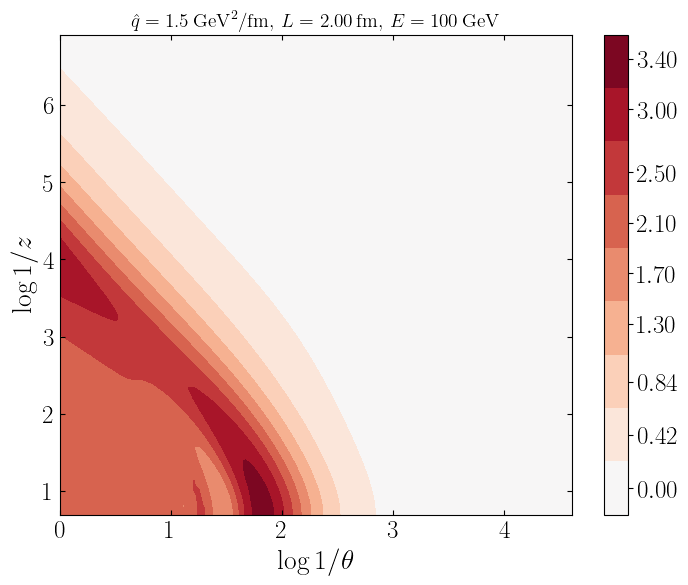

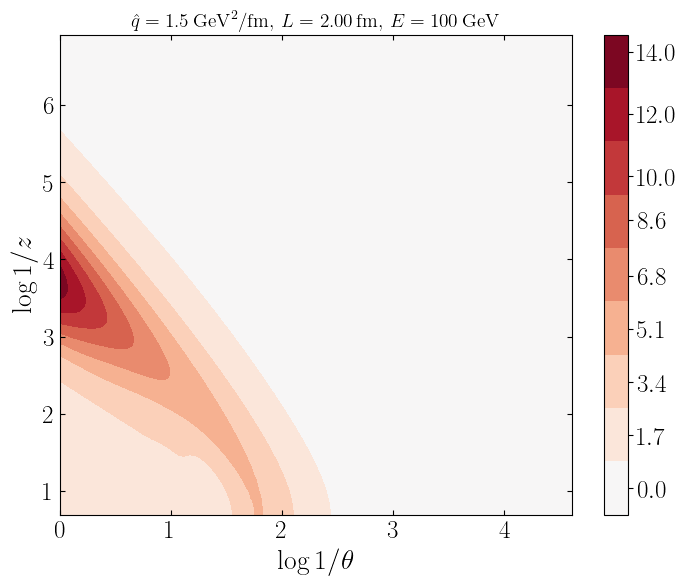

In [122]:
pl(lund,0,time,name='eikonal/Fmed',x=TH,y=Z)
pl(lund_eik,0,time,name='eikonal/Fmed_eik',x=TH,y=Z)
pl(lund_inin,0,time,name='eikonal/inin',x=TH,y=Z)
pl(lund_inin_eik,0,time,name='eikonal/inin_eik',x=TH,y=Z)


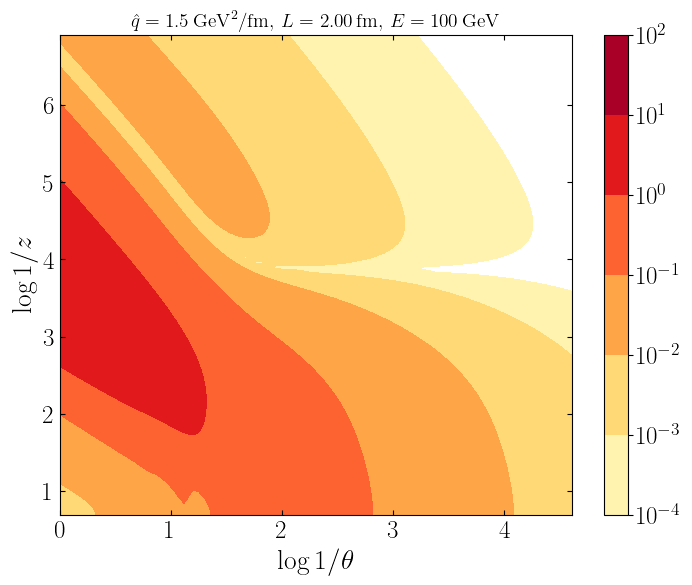

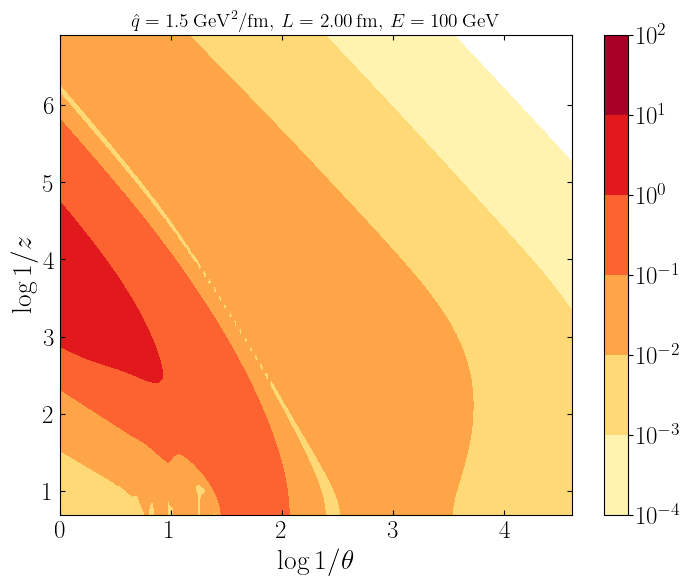

In [123]:
pl(lund_eik_error,0,time,name='eikonal/eik_error',x=TH,y=Z,log=True)
pl(lund_inin_error,0,time,name='eikonal/eik_error_inin',x=TH,y=Z,log=True)

# p plots

In [124]:
L=40
t=L
th=0.2
z=0.4

qhatmix=1.5 #GeV^2/fm
q=qhatmix*25.77 #fm^(-3)
EGev = 100 # Energy in Gev
E = EGev * 5.076 # Conversion factor to fm^-1

In [125]:
points = 100

t_vals = np.linspace(0.001,2,points)

lower_z = 0.01
upper_z = 0.5
log_oneover_z = np.linspace(np.log(1/lower_z),np.log(1/upper_z),points)
z_values = np.exp(-log_oneover_z)

# Use theta as proxy for p, as p ~ z*(1-z)*th*E
lower_th = 0.01
upper_th = 0.9
log_oneover_th = np.linspace(np.log(1/lower_th),np.log(1/upper_th),points)
theta_values = np.exp(-log_oneover_th)

lower_p = w(lower_z)*lower_th
upper_p = w(upper_z)*upper_th
log_oneover_p = np.linspace(np.log(1/lower_p),np.log(1/upper_p),points)
p_values = np.exp(-log_oneover_p)


In [126]:
Z, P = np.meshgrid(log_oneover_z,log_oneover_p)
Z_lin, P_lin = np.meshgrid(z_values,p_values)


In [127]:
print(p_values[0],p_values[-1])
Qs=np.sqrt(q*L)
print(Qs)
print(np.log(1/Qs))

0.05025239999999999 114.21000000000001
39.32174970674627
-3.671777793443187


In [128]:
Qs = np.sqrt(q*L)

p_Qs_values = np.array([])
for z in z_values:
    p_Qs = np.sqrt(q*L)
    p_Qs_values = np.append(p_Qs_values,p_Qs)
log_oneover_p_Qs = np.log(1/p_Qs_values)

p_ho_values = np.array([])
for z in z_values:
    p_ho = (q*w(z))**(1/4)
    p_ho_values = np.append(p_ho_values,p_ho)
log_oneover_p_ho = np.log(1/p_ho_values)

In [129]:
def Fmed_new_scal_p(L,z,p):
    def inte(t,L,z,p):
        pre = 1j*p**2/w(z)
        num = 2*w(z)*O(z)/np.tan(O(z)*t)
        den = 2*w(z)*O(z)/np.tan(O(z)*t)+1j*q*(z**2+(1-z)**2)*(L-t)
        inout = -1/np.cos(O(z)*t)**2*np.exp(-1j*np.tan(O(z)*t)*p**2/(2*w(z)*O(z)))
        return np.real(pre*(num/den*np.exp(-1j*p**2/den)+inout))

    return quad(inte,0,L,args=(L,z,p))[0]

In [130]:
def Fmed_new_scal_p_eik(L,z,p):
    def inte(t,L,z,p):
        pre_inin = 2*p**2/(q*(1-2*z*(1-z))*t**2)
        exp1 = -1j*p**2*t/(2*w(z))
        exp2 = -q*p**2*t**3/(12*w(z)**2)
        exp3 = -q*p**2*(1-2*z*1*(1-z))*(L-t)*t**2/(4*w(z)**2)
        inin = pre_inin*np.exp(exp1)*np.exp(exp2)*(1-np.exp(exp3))

        pre_inout = -1j*p**2/w(z)
        inout = pre_inout*np.exp(exp1)*np.exp(exp2)
        return np.real(inin+inout)

    return quad(inte,0,L,args=(L,z,p))[0]

In [131]:
Fmed_p = np.vectorize(Fmed_new_scal_p)
Fmed_p_eik = np.vectorize(Fmed_new_scal_p_eik)

In [132]:
lund = Fmed_p(L,Z_lin,P_lin)

[]

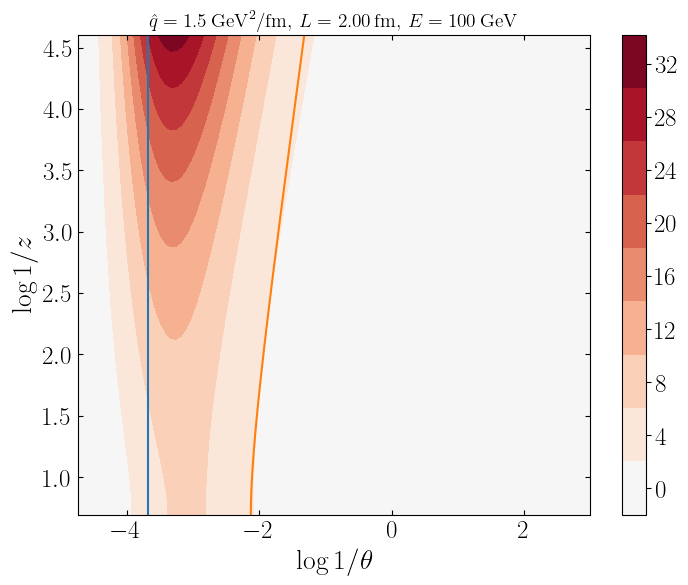

In [133]:

#lund_eik = Fmed_p_eik(L,Z_lin,P_lin)
pl(lund,0,time,x=P,y=Z,log=False,show=False)
#pl(lund_eik,0,time,x=P,y=Z,log=False)

plt.plot(log_oneover_p_Qs,log_oneover_z,label=r"$p=\sqrt{\hat q L}$")
plt.plot(log_oneover_p_ho,log_oneover_z,label=r"$p=(\hat q \omega)^{1/4}$")

plt.plot()

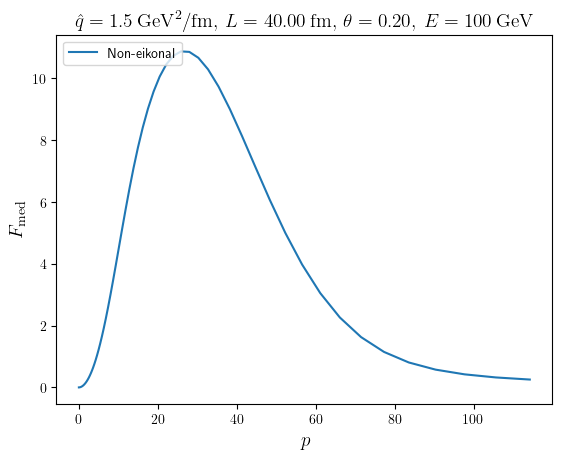

In [134]:
z=0.1

plt.plot(p_values,Fmed_p(t,z,p_values),label=r'Non-eikonal')
#plt.semilogx(p_values,Fmed_p_eik(t,z,p_values),label=r'Eikonal')
plt.legend(loc="upper left")
plt.xlabel(r'$p$',fontsize =14)
plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =14)
plt.title(r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,\theta=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,t,th,EGev),fontsize=14)
#plt.savefig(f'plots/eikonal/Fmed_z_{EGev}.png', bbox_inches='tight')
plt.show()


-3.671777793443187


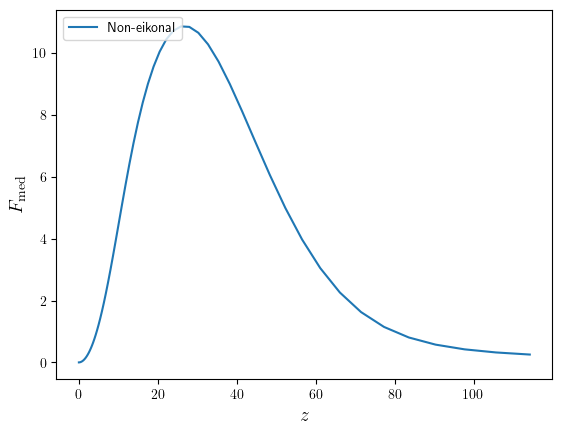

In [135]:
p = Qs
print(np.log(1/p))

plt.plot(p_values,Fmed_p(t,z,p_values),label=r'Non-eikonal')
#plt.semilogx(z_values,Fmed_p_eik(t,z_values,p),label=r'Eikonal')
plt.legend(loc="upper left")
plt.xlabel(r'$z$',fontsize =14)
plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =14)
#plt.title(r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,\theta=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,t,th,EGev),fontsize=14)
#plt.savefig(f'plots/eikonal/Fmed_z_{EGev}.png', bbox_inches='tight')
plt.show()

In [136]:
L

40